# MIXED - Experimental approach using both datasets
This notebook contains the code of our attempts at training the model on a Mixed dataset, using both CIFAKE and RVAA.

Ultimately, using this approach required some prep work, and we decided to implement a combination of data augmentation of RVAA while subsampling the CIFAKE dataset, in order to make the whole sample set more balanced.
Nevertheless, we are satisfied with the results as this approach allowed us to reach 91.8% accuracy.

In [1]:
import torch
from torchvision.models import resnet18, resnet50
import model_utils
import plotter
import data_utils
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset, Subset
import importlib
import torchvision.transforms as transforms
import xai
import numpy as np


seed=42
model_utils.fix_random(seed)
TRAINING_MODE=True
plotter.set_display_mode(True)

# compute the artifacts for a batch
get_result=False

import warnings
warnings.filterwarnings("ignore", category=UserWarning) # fixes PIL not scrollable bug

## Preparing the data

As we're using a mixed approach, we would need to upscale the CIFAKE images to match the size of the other, more complicated ones. Obviously, we will apply all the other transformations needed to the RVAA dataset.

As the CIFAKE dataset is much more oversampled than the RVAA dataset (120'000 vs 1'000 samples) we need to take in consideration a very small subset of CIFAKE in order to create a properly balanced mixed dataset. In particular, we take about 1200 samples from CIFAKE.

In [2]:
IMG_SIZE = 224

transform_cifake = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),  # Convert to RGB
    transforms.Resize((IMG_SIZE, IMG_SIZE)),                # Resize to IMG_SIZE
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

d1 = data_utils.CIFAKEDataset(root_dir="data/CIFAKE", split="train", transform=transform_cifake)
d2 = data_utils.CIFAKEDataset(root_dir="data/CIFAKE", split="test", transform=transform_cifake)
cifake_dataset = ConcatDataset([d1, d2])

# Selecting a subset of the CIFAKE datasets
portion_size = int(0.008 * len(cifake_dataset))
indices = list(range(portion_size))
cifake_dataset = Subset(cifake_dataset, indices)

transform_rvaa = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')), # Convert to RGB
    transforms.Resize(IMG_SIZE),                 # Resize to IMG_SIZE while keeping aspect ratio
    transforms.Lambda(data_utils.pad_to_square), # Apply the dynamic padding to make the image square
    transforms.Resize((IMG_SIZE, IMG_SIZE)),     # Ensure the final image is IMG_SIZExIMG_SIZE
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing "should" help with Pretrained nets
])

rvaa_dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt", transform=transform_rvaa)

# the final dataset that's going to be used
merged_dataset = ConcatDataset([cifake_dataset, rvaa_dataset])

In [3]:
LEARNING_RATE = 3e-4
EPOCHS = 20
BATCH_SIZE = 64
DATASET_NAME = "MIXED"

In [4]:
# WARNING: IF YOU REBUILD THE DATALOADER, THE RESULT WILL DIFFER. RESTART THE KERNEL AND TRAIN AGAIN TO HAVE THE SAME RESULTS.
train_dataset, val_dataset, test_dataset = data_utils.train_test_split((0.7, 0.15), dataset=merged_dataset, isRandom=True)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)

print(len(val_dataset), len(test_dataset), len(train_dataset))

289 290 1351


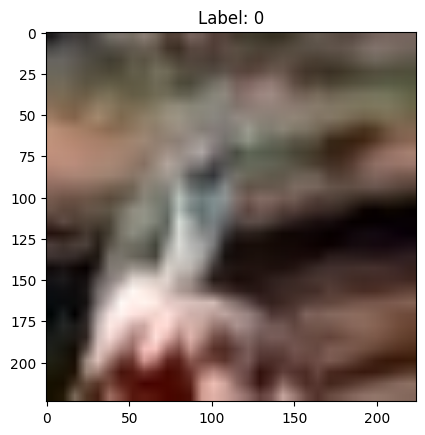

In [5]:
data_utils.show_random_sample(train_dataloader)

## Baseline CNN
We examine the result on a baseline CNN with the same characteristics as the one found in the CIFAKE and RVAA notebooks.

In [6]:
device = model_utils.get_device()
print(f"using {device} device")

baseline_model = model_utils.CNN()
baseline_model.to(device)
model_name = "MIXED_BaseCNN"
optimizer = torch.optim.AdamW(baseline_model.parameters(), lr=LEARNING_RATE)

loss_fn = nn.BCEWithLogitsLoss()
dataloaders = (train_dataloader, val_dataloader)

using cuda device


In [7]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer,
                              baseline_model, model_name, BATCH_SIZE,
                              EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Validation Error:
Accuracy: 79.9%, Avg loss: 0.425130
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Validation Error:
Accuracy: 78.2%, Avg loss: 0.378689
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Validation Error:
Accuracy: 80.6%, Avg loss: 0.355553
New best model found! (based on lowest loss)
...and saved.


Epoch 4/20
-------------------------------
Validation Error:
Accuracy: 82.7%, Avg loss: 0.332039
New best model found! (based on lowest loss)
...and saved.


Epoch 5/20
-------------------------------
Validation Error:
Accuracy: 79.2%, Avg loss: 0.370114


Epoch 6/20
-------------------------------
Validation Error:
Accuracy: 81.7%, Avg loss: 0.433851


Epoch 7/20
-------------------------------
Validation Error:
Accuracy: 83.4%, Avg loss: 0.383746


Epoch 8/20
-------------------------------
Validation Error:
Accuracy: 

Test Error:
Accuracy: 83.1%, Avg loss: 0.312355
Confusion matrix report, tp: 189, fp: 17, fn: 32, tn:52
True


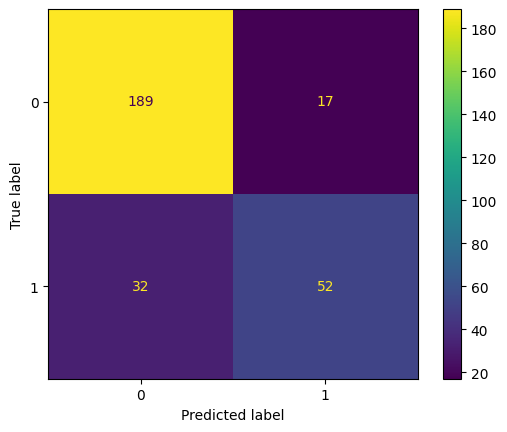

Precision: 0.92, Recall: 0.86, F1-Score: 0.89


(0.31235461235046386, tensor(0.8310, device='cuda:0'))

In [8]:
model_utils.test(test_dataloader, baseline_model, loss_fn, device,
                 model_name=model_name)

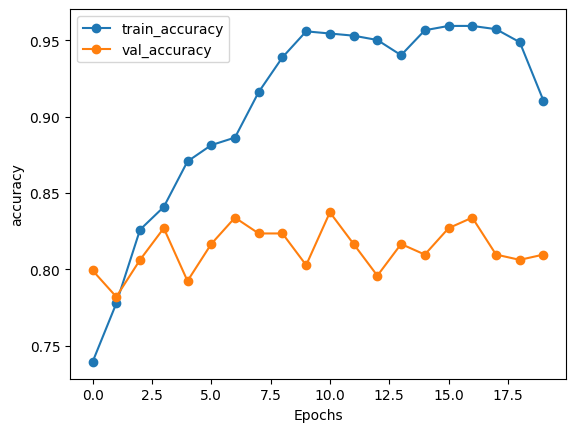

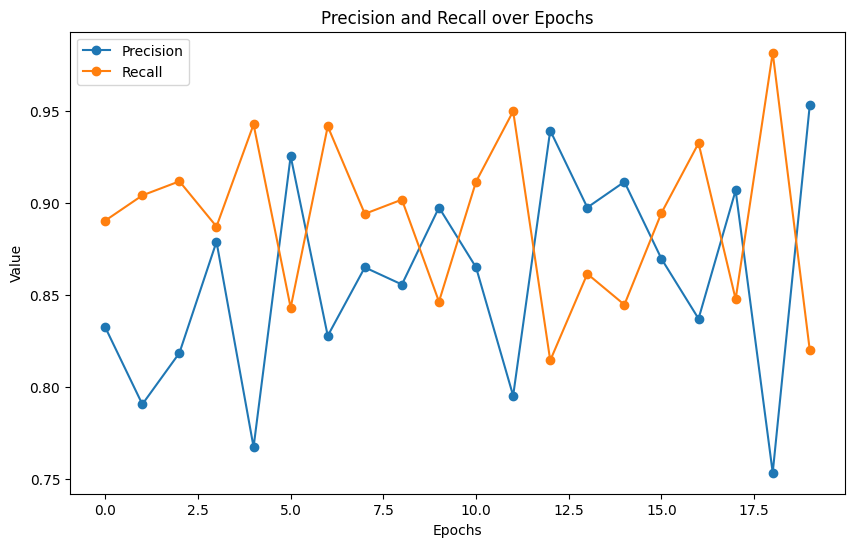

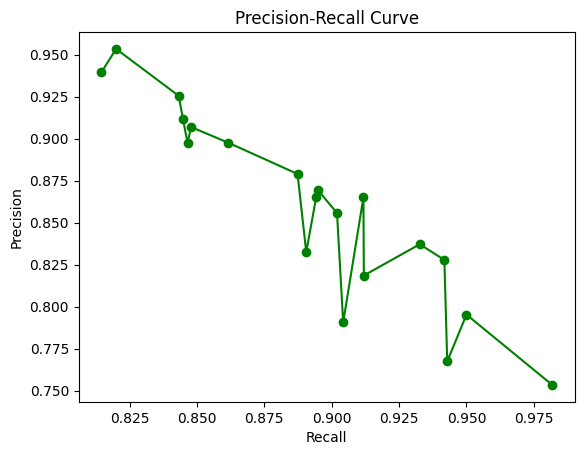

In [9]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

## Model
Since the model that has been giving us great results so far is a ResNet50, we can try and use it again to see if it manages to capture the patterns learned from CIFAKE with the patterns learned from RealVsAiArt.

In [10]:
ft_resnet50 = resnet50(weights='IMAGENET1K_V1')

model_utils.prepare_for_ft(ft_resnet50)
ft_resnet50.to(device)

optimizer = torch.optim.AdamW(ft_resnet50.fc.parameters(), lr=LEARNING_RATE)

dataloaders = (train_dataloader, val_dataloader)

## Training setup
The training is done using 20 epochs and a batch size of 64.
As before, we use a 2-step training method which allows us to train the classification head first and then the feature extractor. As shown in the CIFAKE model, this usually deals pretty good results.

In [11]:
model_name = "MixResNet"
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Validation Error:
Accuracy: 77.2%, Avg loss: 0.476906
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Validation Error:
Accuracy: 80.6%, Avg loss: 0.418488
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Validation Error:
Accuracy: 74.7%, Avg loss: 0.424581


Epoch 4/20
-------------------------------
Validation Error:
Accuracy: 80.3%, Avg loss: 0.379130
New best model found! (based on lowest loss)
...and saved.


Epoch 5/20
-------------------------------
Validation Error:
Accuracy: 83.0%, Avg loss: 0.364493
New best model found! (based on lowest loss)
...and saved.


Epoch 6/20
-------------------------------
Validation Error:
Accuracy: 81.7%, Avg loss: 0.359611
New best model found! (based on lowest loss)
...and saved.


Epoch 7/20
-------------------------------
Validation Error:
Accuracy: 82.4%, Avg loss: 0.357869
New best model

In [12]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device)

Test Error:
Accuracy: 85.5%, Avg loss: 0.284776
Confusion matrix report, tp: 188, fp: 18, fn: 24, tn:60
Precision: 0.91, Recall: 0.89, F1-Score: 0.90


(0.28477630615234373, tensor(0.8552, device='cuda:0'))

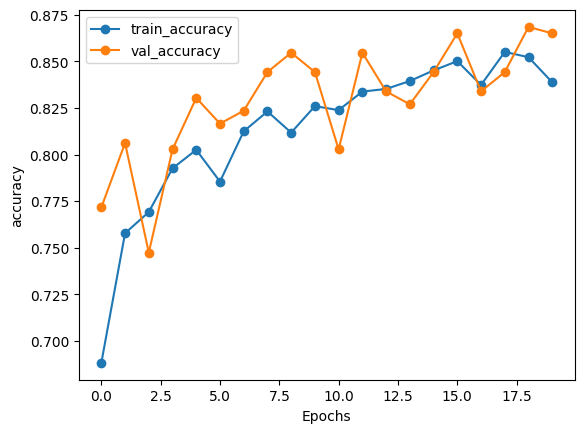

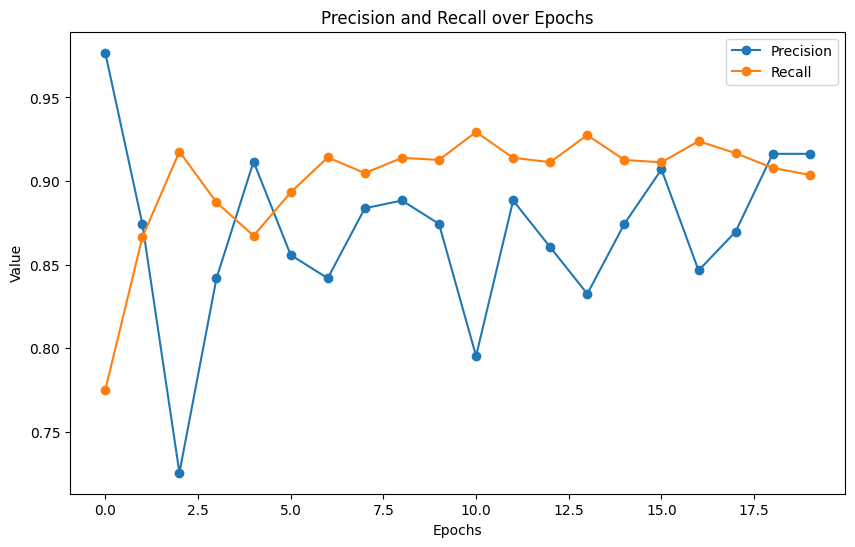

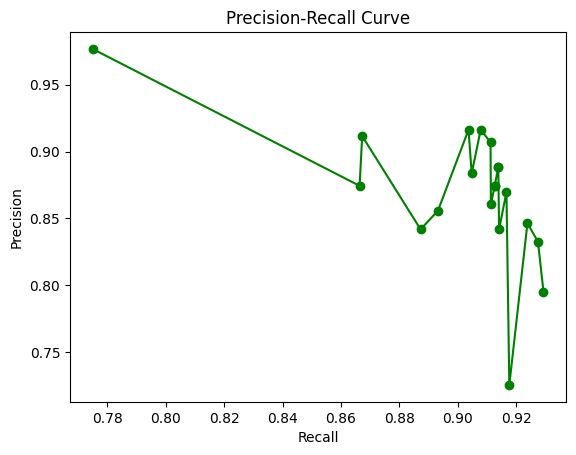

In [13]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

### Fine-tuning step 2
The second step of the fine-tuning procedure consists in training the feature extractor using the fine-tuned classification head.

This step is fundamental to achieve good results.

In [14]:
for param in ft_resnet50.parameters():
    param.requires_grad = True


optimizer = torch.optim.AdamW(ft_resnet50.parameters(), lr=LEARNING_RATE)

In [15]:
model_name = "MixResNet_beefy"
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Validation Error:
Accuracy: 85.5%, Avg loss: 0.537351
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Validation Error:
Accuracy: 83.7%, Avg loss: 0.460653
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Validation Error:
Accuracy: 86.5%, Avg loss: 0.568696


Epoch 4/20
-------------------------------
Validation Error:
Accuracy: 83.4%, Avg loss: 0.611795


Epoch 5/20
-------------------------------
Validation Error:
Accuracy: 87.5%, Avg loss: 0.345636
New best model found! (based on lowest loss)
...and saved.


Epoch 6/20
-------------------------------
Validation Error:
Accuracy: 87.9%, Avg loss: 0.535960


Epoch 7/20
-------------------------------
Validation Error:
Accuracy: 86.2%, Avg loss: 0.621919


Epoch 8/20
-------------------------------
Validation Error:
Accuracy: 84.8%, Avg loss: 0.491169


Epoch 9/20
--------------------

Test Error:
Accuracy: 90.3%, Avg loss: 0.241914
Confusion matrix report, tp: 199, fp: 7, fn: 21, tn:63
True


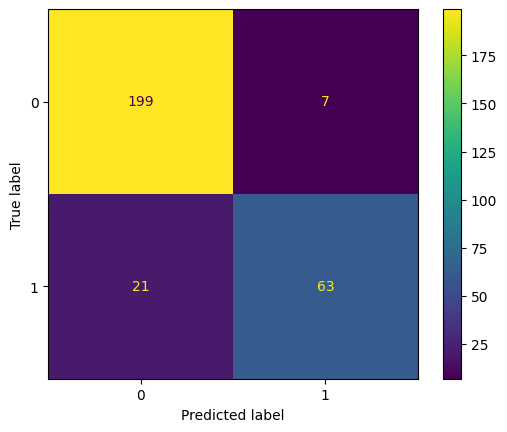

Precision: 0.97, Recall: 0.90, F1-Score: 0.93


(0.24191365838050843, tensor(0.9034, device='cuda:0'))

In [16]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device, model_name=model_name)

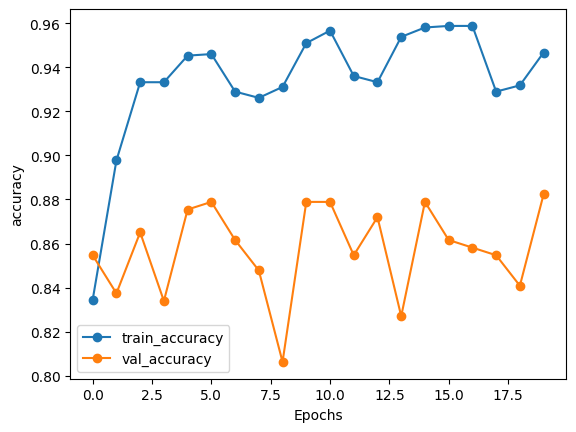

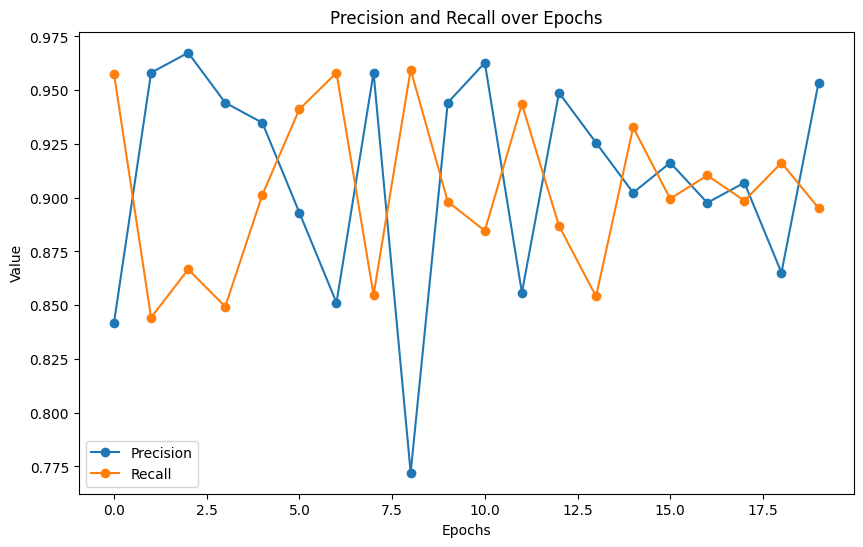

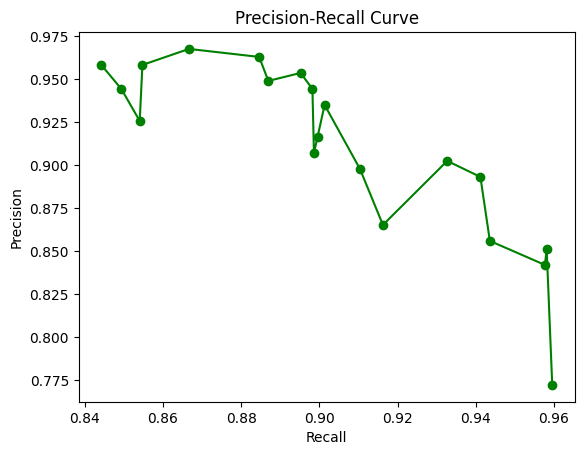

In [17]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts 
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

# xAI test
As with the other results, we compute the xAI result using the LIME, AblationCAM and ScoreCAM explainers.
In particular, ScoreCAM and AblationCAM will target the last three layers.

In the following images, we'll show some samples of using AblationCAM and LIME.

In [18]:
target_layers = [ft_resnet50.layer2, ft_resnet50.layer3, ft_resnet50.layer4]

100%|██████████| 64/64 [02:35<00:00,  2.42s/it]


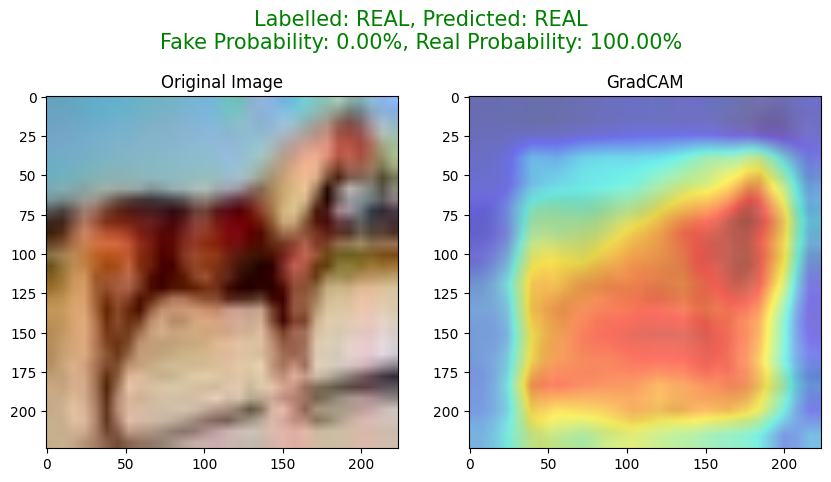

In [19]:
xai.explain_gradcam_single_image(train_dataloader,
                                ft_resnet50, target_layers, model_name = model_name,
                                dataset_name = DATASET_NAME,
                                index = 3)

By using upscaled CIFAKE images, it is clear how AblationCAM can give better explanations and it's generally less prone to malformed explanation artifacts.

  0%|          | 0/1000 [00:00<?, ?it/s]

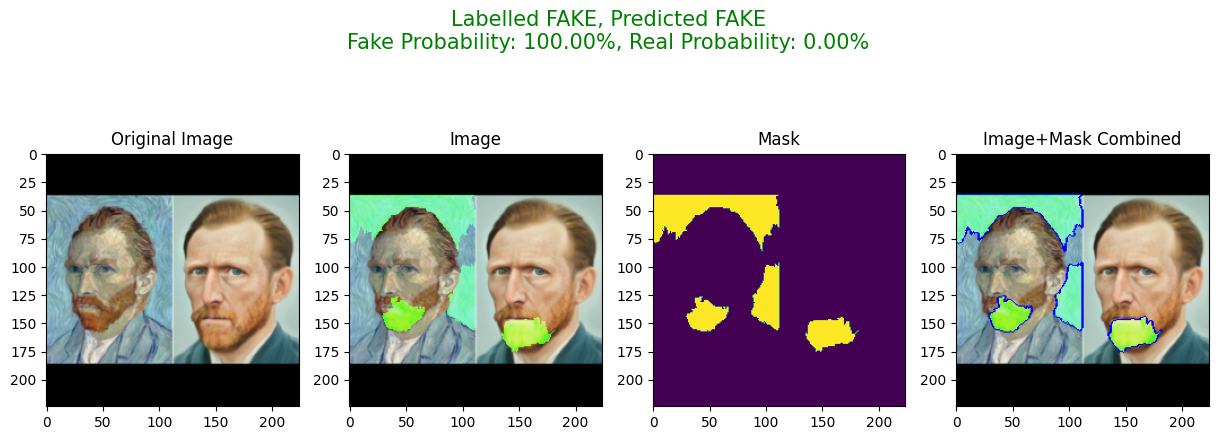

In [20]:
xai.explain_lime_single_image(train_dataloader, ft_resnet50)

### Batch visualization
This code allows us to save some samples of a batch of AblationCAM and LIME, and it's only for data analysis purposes.

In [ ]:
xai.explain_gradcam_batch(test_dataloader, test_dataloader.batch_size, ft_resnet50, target_layers, model_name, DATASET_NAME)

In [ ]:
xai.explain_lime_batch(test_dataloader, test_dataloader.batch_size, ft_resnet50,
                                model_name=model_name, dataset_name=DATASET_NAME,
                                )

## Data augmentation
As mentioned before, the RVAA is much underrepresented. As such, we need to apply the augmented transformations only on the RVAA dataset, while keeping only a fraction of the CIFAKE dataset.

In [22]:
import data_utils
# Load CIFAKE dataset and take a small subset
cifake_train = data_utils.CIFAKEDataset(root_dir="data/CIFAKE", split="train", transform=transform_cifake)
cifake_test = data_utils.CIFAKEDataset(root_dir="data/CIFAKE", split="test", transform=transform_cifake)

# Take 0.8% of CIFAKE and split into train, val, and test
portion_size_train = int(0.0135 * len(cifake_train))
indices = torch.randperm(len(cifake_train))[:portion_size_train]
cifake_train = Subset(cifake_train, indices)

portion_size_test = int(0.0135 * len(cifake_test))
cifake_subset_test = Subset(cifake_test, list(range(portion_size_test)))

cifake_val, cifake_test = data_utils.train_test_split(
    split_ratio=(0.5),  # 85% train, 15% val
    dataset=cifake_subset_test,
    isRandom=True
)

print(len(cifake_train), len(cifake_test), len(cifake_val))

1350 135 135


#### Preparing the Augmented part of the dataset
In order to augment the RVAA data, we simply apply:
- a random rotation
- a random horizontal flip (i.e. the image will be flipped with a 50/50 chance)

In previous attempts, we also tried to apply cropping. However, given that the dataset contains images which are put side by side with non-AI images, it can be destructive to the training process, as a random crop could contain a sample of a non-AI image. As such, we decided to avoid using it.

It is important to consider that only part of the RVAA dataset is used to create the augmented dataset.

In [23]:
augmented_transform_rvaa = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')), # Convert to RGB
    transforms.Resize(IMG_SIZE),                 # Resize to IMG_SIZE while keeping aspect ratio
    transforms.Lambda(data_utils.pad_to_square), # Apply the dynamic padding to make the image square
    transforms.Resize((IMG_SIZE, IMG_SIZE)),     # Ensure the final image is IMG_SIZExIMG_SIZE
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flip
    transforms.RandomRotation(90),  # Randomly rotate the image by up to 90 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing "should" help with Pretrained nets
])

In [24]:
import copy
import random

# Create a deep copy of the dataset
original_dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt", transform=transform_rvaa)
# make a deepcopy to ensure it has the same order
rvaa_dataset_copy = copy.deepcopy(original_dataset)

# we are doing the same thing as the train_test_split function
train_size = int(0.8 * len(original_dataset))
val_size = int(0.10 * len(original_dataset))
test_size = len(original_dataset) - train_size - val_size

generator = torch.Generator()
generator.manual_seed(seed)
train_indices, val_indices, test_indices = torch.utils.data.random_split(
    range(len(original_dataset)),
    [train_size, val_size, test_size],
    generator=generator
)

rvaa_train_dataset = Subset(original_dataset, train_indices)
rvaa_val_dataset = Subset(original_dataset, val_indices)
rvaa_test_dataset = Subset(original_dataset, test_indices)

augmented_size = int(0.8 * len(rvaa_train_dataset))
augmented_indices = random.sample(train_indices.indices, augmented_size)

rvaa_dataset_copy.transform = augmented_transform_rvaa
augmented_train_dataset = Subset(rvaa_dataset_copy, augmented_indices)

combined_train_dataset_rvaa = ConcatDataset([rvaa_train_dataset, augmented_train_dataset])

print(len(combined_train_dataset_rvaa), len(rvaa_test_dataset), len(rvaa_val_dataset))

1396 97 97


In [25]:
# Ensure augmented indices are within the training set
assert set(augmented_indices).issubset(train_indices), "Augmented indices include non-training data!"

# Ensure no overlap between validation and augmented data
assert not set(val_indices).intersection(augmented_indices), "Data leakage in validation set!"

# Ensure no overlap between test and augmented data
assert not set(test_indices).intersection(augmented_indices), "Data leakage in test set!"


In [26]:
train_dataset = ConcatDataset([cifake_train, combined_train_dataset_rvaa])
val_dataset = ConcatDataset([cifake_val, rvaa_val_dataset])
test_dataset = ConcatDataset([cifake_test, rvaa_test_dataset])

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

Training dataset size: 2746
Validation dataset size: 232
Testing dataset size: 232


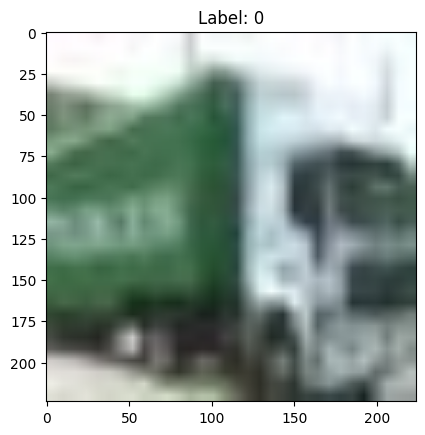

In [27]:
data_utils.show_random_sample(train_dataloader)

In [28]:
ft_resnet50 = resnet50(weights='IMAGENET1K_V1')
device = model_utils.get_device()
print(f"using {device} device")

model_utils.prepare_for_ft(ft_resnet50)
ft_resnet50.to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(ft_resnet50.fc.parameters(), lr=LEARNING_RATE)

dataloaders = (train_dataloader, val_dataloader)

using cuda device


### Training Step 1
Only the classification head is trained in the first step. 

In [29]:
model_name = "Augmented_MixResNet"
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Training loss: 0.617565, train accuracy: 62.23%  [ 2560/ 2746]
Validation Error:
Accuracy: 75.9%, Avg loss: 0.589905
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Training loss: 0.609132, train accuracy: 69.45%  [ 2560/ 2746]
Validation Error:
Accuracy: 69.8%, Avg loss: 0.586922
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Training loss: 0.564709, train accuracy: 71.41%  [ 2560/ 2746]
Validation Error:
Accuracy: 80.2%, Avg loss: 0.511581
New best model found! (based on lowest loss)
...and saved.


Epoch 4/20
-------------------------------
Training loss: 0.520919, train accuracy: 72.38%  [ 2560/ 2746]
Validation Error:
Accuracy: 75.4%, Avg loss: 0.532773


Epoch 5/20
-------------------------------
Training loss: 0.542225, train accuracy: 74.88%  [ 2560/ 2746]
Validation Error:
Accuracy: 79.3%, Avg loss: 0.494703
New best model 

Test Error:
Accuracy: 82.3%, Avg loss: 0.427213
Confusion matrix report, tp: 149, fp: 29, fn: 12, tn:42
True


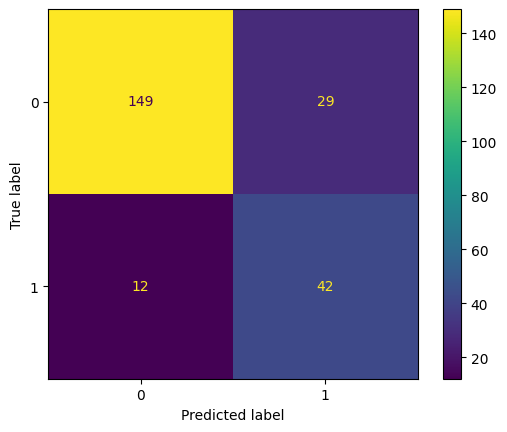

Precision: 0.84, Recall: 0.93, F1-Score: 0.88


(0.42721275985240936, tensor(0.8233, device='cuda:0'))

In [30]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device, model_name=model_name)

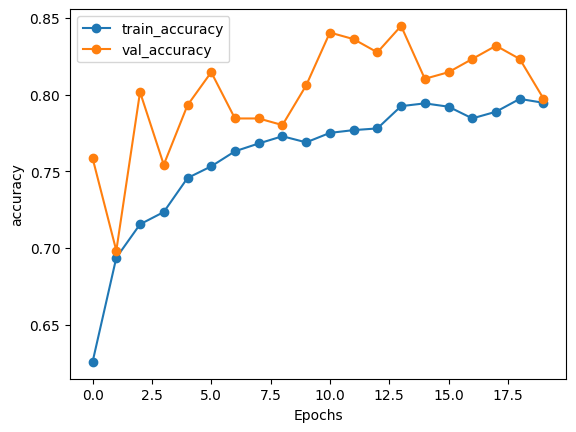

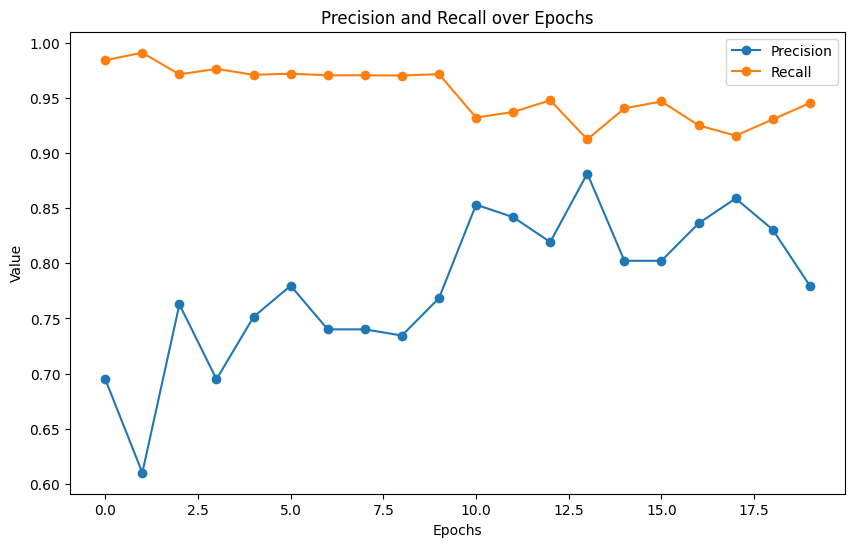

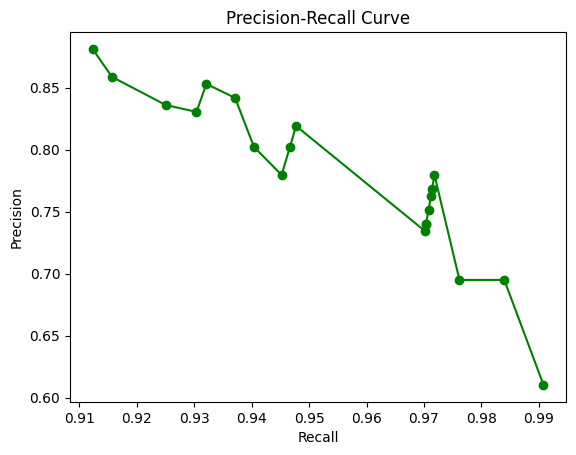

In [31]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

### Training Step 2
The feature extractor is trained on the second step.

In [32]:
for param in ft_resnet50.parameters():
    param.requires_grad = True


optimizer = torch.optim.AdamW(ft_resnet50.parameters(), lr=LEARNING_RATE)

In [33]:
model_name = "Augmented_MixResNet_beefy"
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Training loss: 0.273896, train accuracy: 76.99%  [ 2560/ 2746]
Validation Error:
Accuracy: 82.8%, Avg loss: 0.427464
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Training loss: 0.466164, train accuracy: 88.55%  [ 2560/ 2746]
Validation Error:
Accuracy: 84.1%, Avg loss: 0.471524


Epoch 3/20
-------------------------------
Training loss: 0.206326, train accuracy: 93.09%  [ 2560/ 2746]
Validation Error:
Accuracy: 90.5%, Avg loss: 0.298443
New best model found! (based on lowest loss)
...and saved.


Epoch 4/20
-------------------------------
Training loss: 0.203771, train accuracy: 94.49%  [ 2560/ 2746]
Validation Error:
Accuracy: 86.2%, Avg loss: 0.400771


Epoch 5/20
-------------------------------
Training loss: 0.164442, train accuracy: 93.28%  [ 2560/ 2746]
Validation Error:
Accuracy: 76.7%, Avg loss: 1.058347


Epoch 6/20
-------------------------------
Training loss: 0.126211, trai

Test Error:
Accuracy: 91.4%, Avg loss: 0.248182
Confusion matrix report, tp: 166, fp: 12, fn: 8, tn:46
True


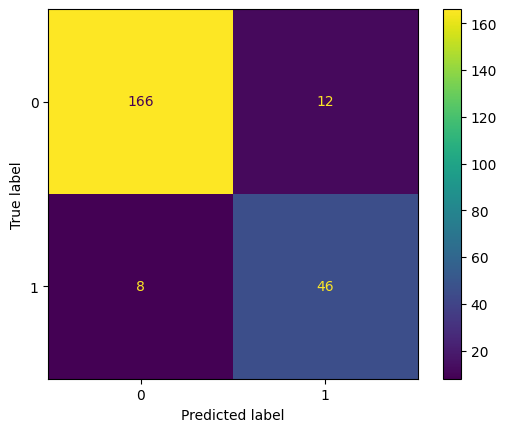

Precision: 0.93, Recall: 0.95, F1-Score: 0.94


(0.2481822334229946, tensor(0.9138, device='cuda:0'))

In [34]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device, model_name=model_name)

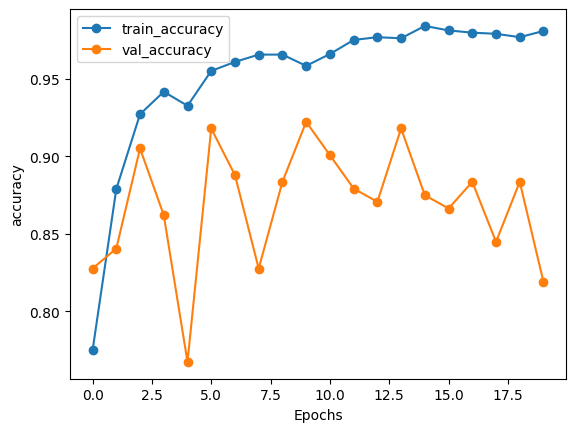

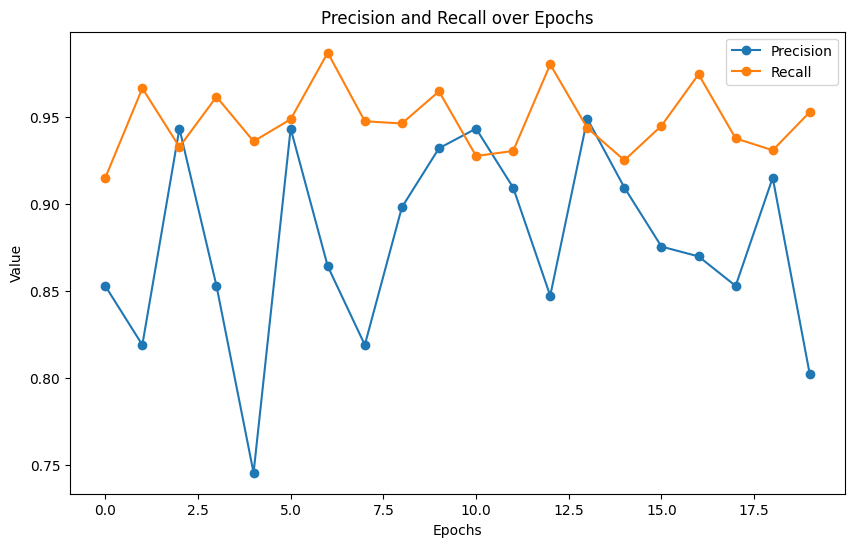

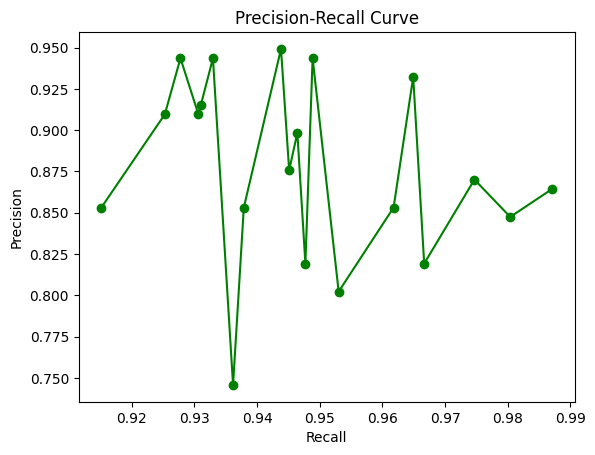

In [35]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts 
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

### AblationCAM + LIME evaluation

100%|██████████| 64/64 [00:56<00:00,  1.14it/s]


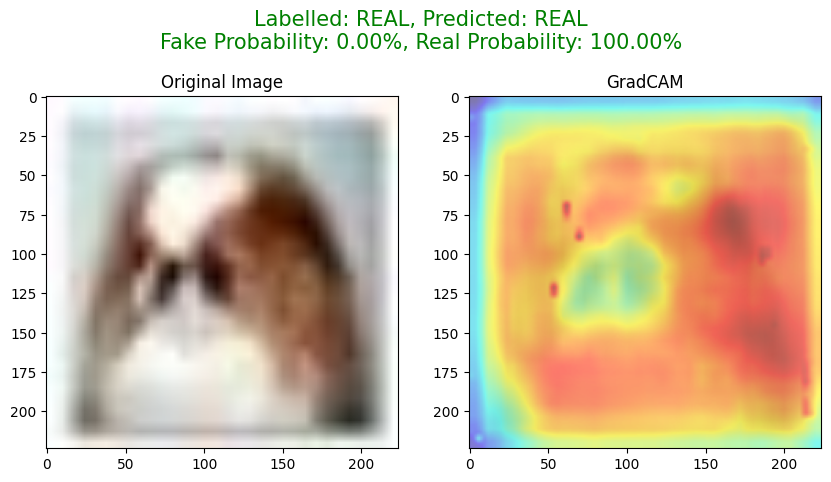

In [ ]:
target_layers = [ft_resnet50.layer2, ft_resnet50.layer3, ft_resnet50.layer4]
xai.explain_gradcam_single_image(test_dataloader,
                                ft_resnet50, target_layers, model_name = model_name,
                                dataset_name = DATASET_NAME,
                                index = 3)

  0%|          | 0/1000 [00:00<?, ?it/s]

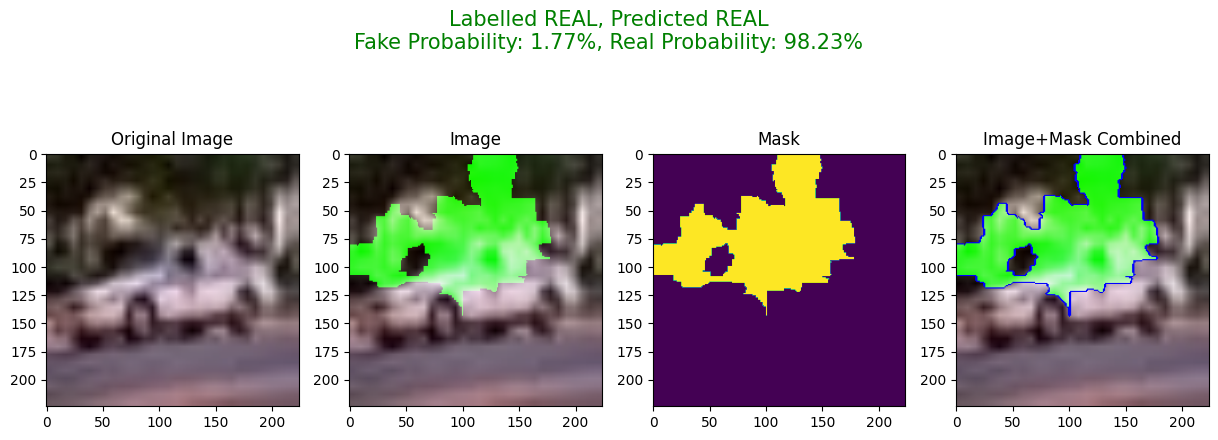

In [37]:
xai.explain_lime_single_image(test_dataloader, ft_resnet50,model_name = model_name,
                                dataset_name = DATASET_NAME)

### Batch visualization
This code allows us to save some samples of a batch of AblationCAM and LIME, and it's only for data analysis purposes.

In [ ]:
if get_result:
    xai.explain_gradcam_batch(test_dataloader, test_dataloader.batch_size, ft_resnet50, target_layers, model_name, DATASET_NAME)

In [ ]:
if get_result:
    xai.explain_lime_batch(test_dataloader, test_dataloader.batch_size, ft_resnet50,
                                model_name=model_name, dataset_name=DATASET_NAME,
                                )